1. 📦 Install Required Libraries

In [2]:
!pip install networkx

^C


In [ ]:
# These URLs are matched to Colab's default PyTorch 2.0 and CUDA 11.8
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 20.1 MB/s eta 0:00:00


In [3]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)


Torch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4


NameError: name 'mini_all_routes' is not defined

2. 🧱 Build GNN Graphs from JSON

In [86]:
import torch
from torch_geometric.data import Data
import json

# Define hold types and helper functions
HOLD_TYPES = ['jug', 'crimp', 'sloper', 'pinch', 'edge']
type_to_onehot = {t: [int(i == j) for i in range(len(HOLD_TYPES))] for j, t in enumerate(HOLD_TYPES)}

def encode_grade(grade_str):
    return int(grade_str.replace("V", ""))

def normalize_coord(val, max_val):
    return val / max_val

def is_reachable(h1, h2, threshold=0.15):
    dx = h1["x"] - h2["x"]
    dy = h1["y"] - h2["y"]
    dist = (dx**2 + dy**2) ** 0.5
    return dist < threshold

def route_to_graph(route):
    wall_w = route["wall_width"]
    wall_h = route["wall_height"]
    holds = route["holds"]

    x_list = []
    edge_index = []

    for h in holds:
        x_norm = h["x"] / wall_w
        y_norm = h["y"] / wall_h
        area_norm = (h["width"] * h["height"]) / (wall_w * wall_h)
        type_oh = type_to_onehot.get(h["type"].lower(), [0]*len(HOLD_TYPES))
        x_list.append([x_norm, y_norm, area_norm] + type_oh)

    for i in range(len(holds)):
        for j in range(len(holds)):
            if i != j:
                h1 = {"x": holds[i]["x"] / wall_w, "y": holds[i]["y"] / wall_h}
                h2 = {"x": holds[j]["x"] / wall_w, "y": holds[j]["y"] / wall_h}
                if is_reachable(h1, h2):
                    edge_index.append([i, j])

    x = torch.tensor(x_list, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor([encode_grade(route["grade"])], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)


Graphs

In [87]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_route_graph(data_obj, route_id=None, image_name=None):
    G = nx.DiGraph()

    # Add nodes with (x, y) positions
    for i, node_feat in enumerate(data_obj.x):
        x = node_feat[0].item()
        y = node_feat[1].item()
        G.add_node(i, pos=(x, -y))  # invert y for visual "top-down"

    # Add edges
    edge_list = data_obj.edge_index.t().tolist()
    G.add_edges_from(edge_list)

    # Plot
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, arrows=True)

    # Title
    title = route_id or "Unnamed Route"
    if image_name:
        title += f"\n({image_name})"
    plt.title(title)
    plt.axis("off")
    plt.show()


3. 🧪 Load All Route Graphs

In [88]:
with open("/content/stoneco_all_routesv1.json") as f:
    raw_routes = json.load(f)

graphs = [route_to_graph(r) for r in raw_routes if r["grade"] is not None]
print(f"✅ Loaded {len(graphs)} graphs from JSON")



✅ Loaded 61 graphs from JSON


4. 🧠 Define GNN Model

In [89]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class RouteGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(x)


🔍 Route ID: green_V8-1_green
🖼 Image: green_V8-1.jpg
#️⃣ Holds: 11, 🧗‍♂️ Edges: 10


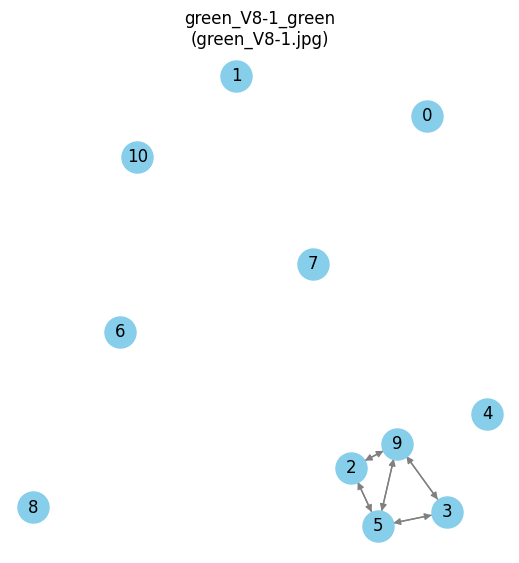

🔍 Route ID: yellow_V0-1_yellow
🖼 Image: yellow_V0-1.jpg
#️⃣ Holds: 16, 🧗‍♂️ Edges: 68


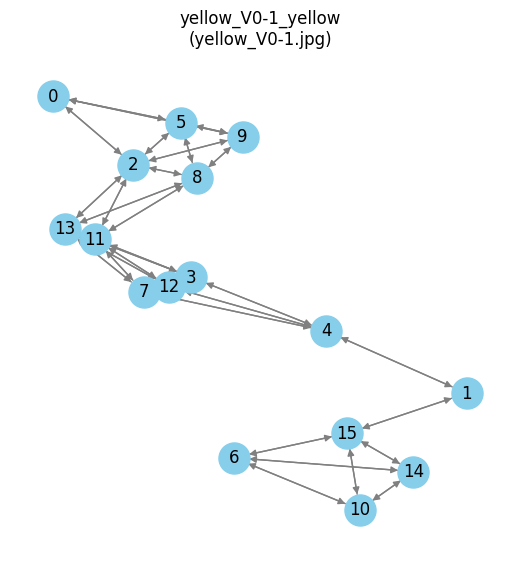

🔍 Route ID: blue_V6-1_blue
🖼 Image: blue_V6-1.jpg
#️⃣ Holds: 9, 🧗‍♂️ Edges: 10


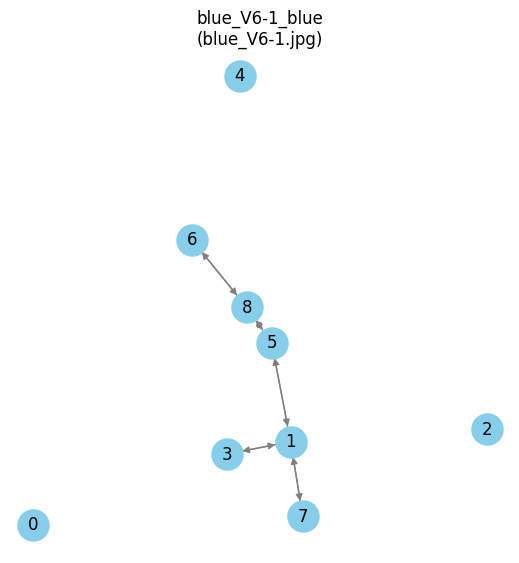

🔍 Route ID: pink_V9-1_pink
🖼 Image: pink_V9-1.jpg
#️⃣ Holds: 11, 🧗‍♂️ Edges: 14


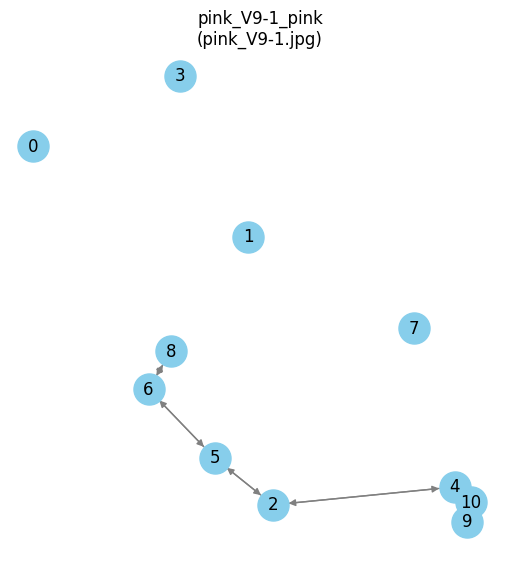

🔍 Route ID: yellow_V0-2_yellow
🖼 Image: yellow_V0-2.jpg
#️⃣ Holds: 15, 🧗‍♂️ Edges: 12


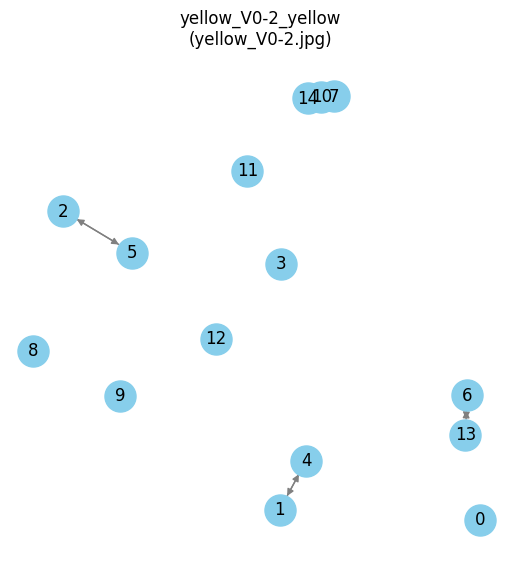

In [90]:
# Show first 5 route graphs
for i in range(5):
    graph = graphs[i]
    route_info = raw_routes[i]
    route_id = route_info.get("route_id")
    image_name = route_info.get("image")

    print(f"🔍 Route ID: {route_id}")
    print(f"🖼 Image: {image_name}")
    print(f"#️⃣ Holds: {graph.num_nodes}, 🧗‍♂️ Edges: {graph.num_edges}")
    plot_route_graph(graph, route_id, image_name)


5. 🏋️‍♂️ Train the GNN

In [96]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(graphs, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

model = RouteGNN(in_channels=8, hidden_channels=64, num_classes=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(700):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 6.8228
Epoch 2, Loss: 6.6159
Epoch 3, Loss: 6.4439
Epoch 4, Loss: 6.3932
Epoch 5, Loss: 6.2870
Epoch 6, Loss: 6.2011
Epoch 7, Loss: 6.1227
Epoch 8, Loss: 5.9850
Epoch 9, Loss: 5.8773
Epoch 10, Loss: 5.7649
Epoch 11, Loss: 5.6225
Epoch 12, Loss: 5.5017
Epoch 13, Loss: 5.4189
Epoch 14, Loss: 5.3126
Epoch 15, Loss: 5.2543
Epoch 16, Loss: 5.1830
Epoch 17, Loss: 5.1135
Epoch 18, Loss: 5.0787
Epoch 19, Loss: 4.9616
Epoch 20, Loss: 5.0045
Epoch 21, Loss: 4.9153
Epoch 22, Loss: 4.7954
Epoch 23, Loss: 4.9964
Epoch 24, Loss: 4.7541
Epoch 25, Loss: 4.9308
Epoch 26, Loss: 4.6144
Epoch 27, Loss: 4.7366
Epoch 28, Loss: 4.6084
Epoch 29, Loss: 4.5778
Epoch 30, Loss: 4.5131
Epoch 31, Loss: 4.6024
Epoch 32, Loss: 4.4674
Epoch 33, Loss: 4.4198
Epoch 34, Loss: 4.3423
Epoch 35, Loss: 4.3184
Epoch 36, Loss: 4.1786
Epoch 37, Loss: 4.2111
Epoch 38, Loss: 4.2219
Epoch 39, Loss: 4.1564
Epoch 40, Loss: 4.0879
Epoch 41, Loss: 4.0708
Epoch 42, Loss: 3.9279
Epoch 43, Loss: 3.9816
Epoch 44, Loss: 3.88

Evaluate

In [99]:
def encode_grade(grade_str):
    return int(grade_str.replace("V", ""))

def decode_grade(index):
    return f"V{index}"

model.eval()

correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = out.argmax(dim=1)

        for p, y in zip(pred, batch.y):
            pred_val = p.item()
            true_val = y.item()
            pred_label = decode_grade(pred_val)
            true_label = decode_grade(true_val)

            is_correct = abs(pred_val - true_val) <= 3
            if is_correct:
                correct += 1
            total += 1

            result_str = "✅ Correct" if is_correct else "❌ Wrong"
            print(f"Predicted: {pred_label}, Actual: {true_label} → {result_str}")

accuracy = correct / total if total > 0 else 0
print(f"\n🎯 Accuracy within ±1 grade: {accuracy:.2%}")



Predicted: V6, Actual: V8 → ✅ Correct
Predicted: V6, Actual: V2 → ❌ Wrong
Predicted: V3, Actual: V2 → ✅ Correct
Predicted: V3, Actual: V6 → ✅ Correct
Predicted: V3, Actual: V7 → ❌ Wrong
Predicted: V4, Actual: V7 → ✅ Correct
Predicted: V0, Actual: V5 → ❌ Wrong
Predicted: V6, Actual: V2 → ❌ Wrong
Predicted: V1, Actual: V1 → ✅ Correct
Predicted: V3, Actual: V6 → ✅ Correct
Predicted: V9, Actual: V5 → ❌ Wrong
Predicted: V0, Actual: V4 → ❌ Wrong
Predicted: V0, Actual: V1 → ✅ Correct

🎯 Accuracy within ±1 grade: 53.85%


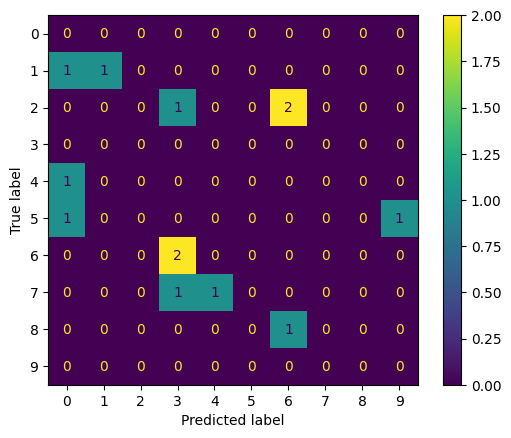

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = out.argmax(dim=1)
        y_true.extend(batch.y.tolist())
        y_pred.extend(pred.tolist())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
torch.save(model.state_dict(), "route_gnn_weights.pth")